<a href="https://www.kaggle.com/code/aziztaktak/spaceship-titanic?scriptVersionId=111574625" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Hi and Welcome to my submission to Kaggle's Spaceship competition :D!
Quite the unique theme to be fair! 
I hope you learn as much as you can from my work, I will be posting my information in the bottom for any questions or inqueries. Feel free to copy this notebook and use it :D!

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
import warnings
warnings.filterwarnings('ignore')

In [3]:
train=pd.read_csv('../input/spaceship-titanic/train.csv')
test=pd.read_csv('../input/spaceship-titanic/test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
#Dropping unnecessary cols
train = train.drop(['PassengerId','Name'], axis=1)
test = test.drop(['PassengerId','Name'], axis=1)
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


Alright so, we have 6 numerical collumns and 5 catergorical. Our target data <b>Transported</b> is boolean but will get encoded into 0's and 1's later on. 

# Data Visualisation and EDA

In [6]:
# Extracting categorical and numerical columns

cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype != 'object']

**Numerical:**

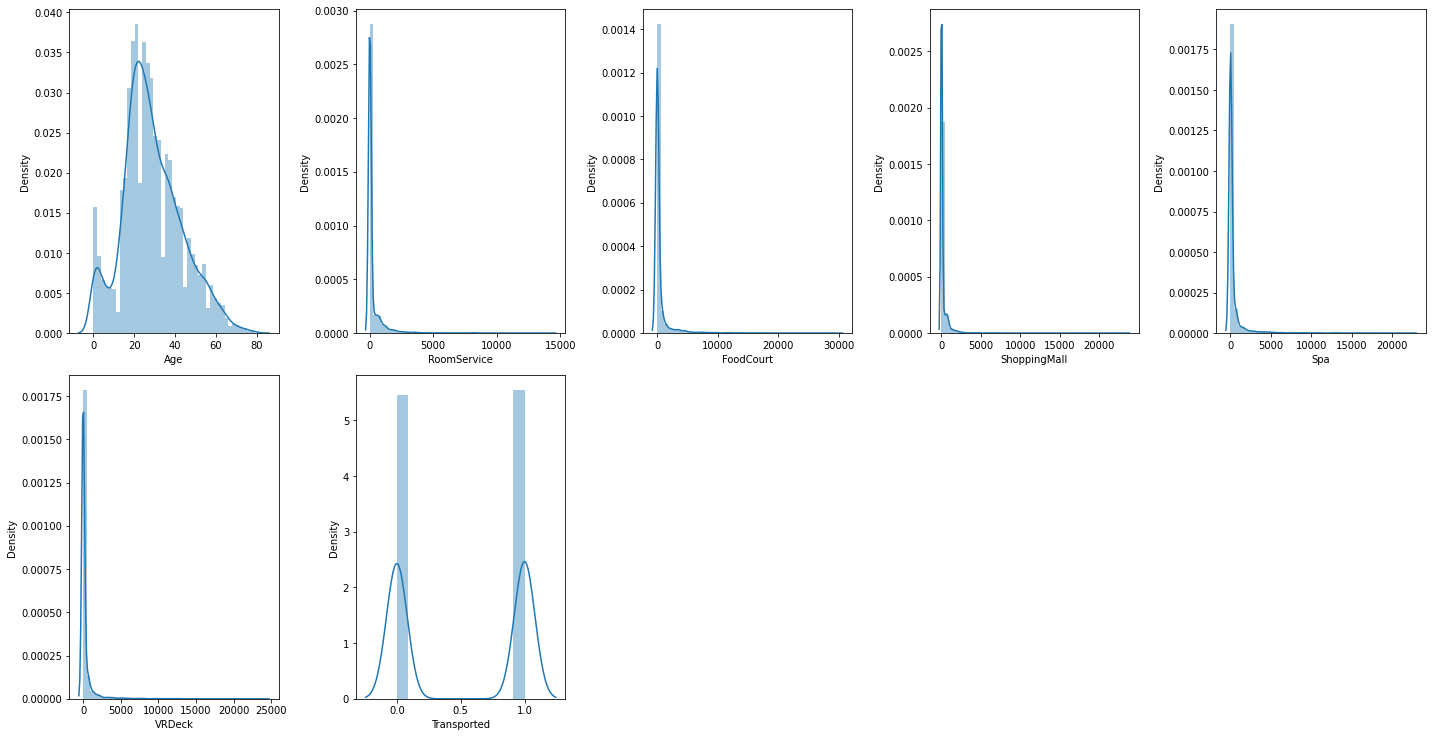

In [7]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(train[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

Okay oof, most of the numerical data has obvious skewness, we're gonna have to apply some transformation to the data to fix that.

# Side Note: 
This is quite amazing though, Transported is not imbalaced whatsoever, almost perfect 50/50 partition, What a miracle.

**Categorical**

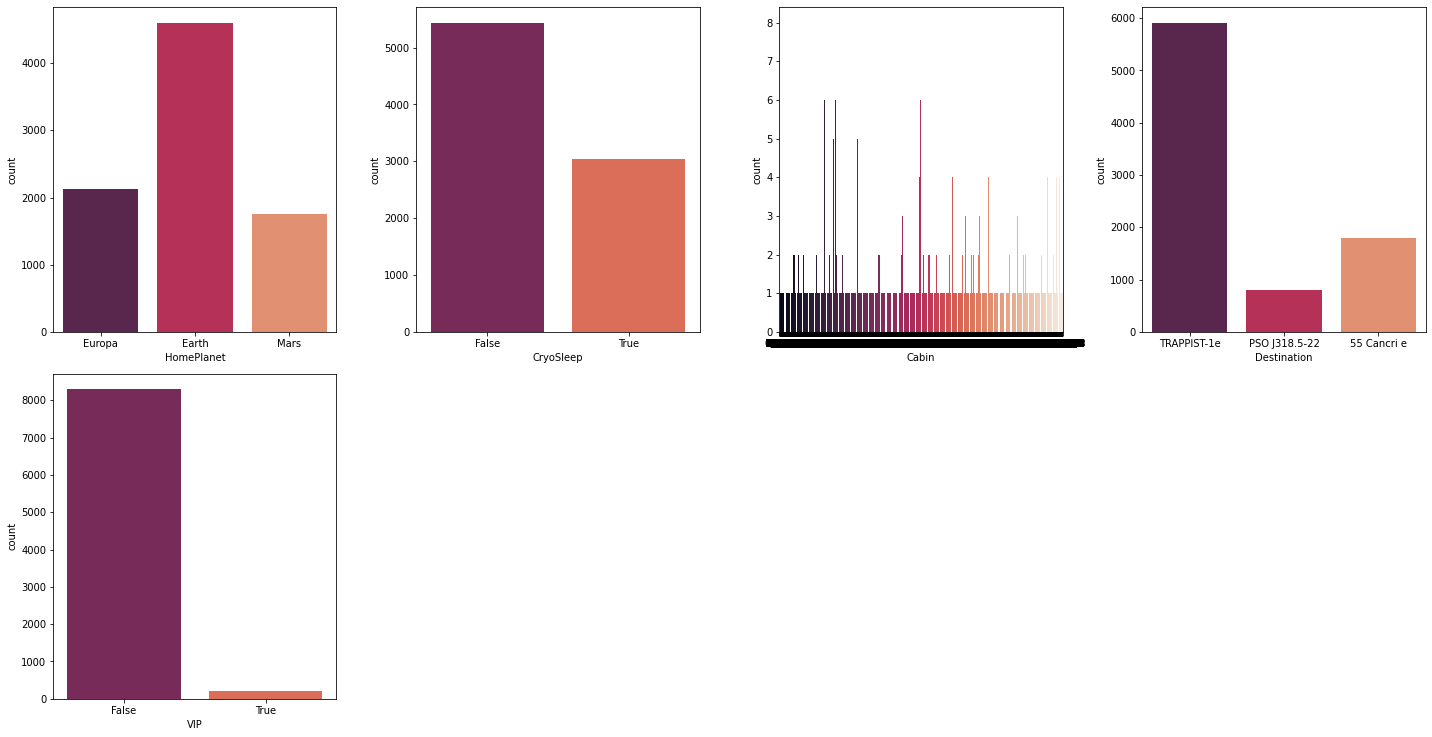

In [8]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1

for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(train[column], palette = 'rocket')
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

Well this is quite interesting, the cabin data presents quite a bit of values, but the rest seems fine except for the VIP data which is quite imbalanced.
Tho Most people aren't VIP's so the partition makes sense.

In [9]:
from matplotlib import style
missing=train.isna().sum().sort_values(ascending=False)
print(missing)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64


In [10]:
train.shape

(8693, 12)

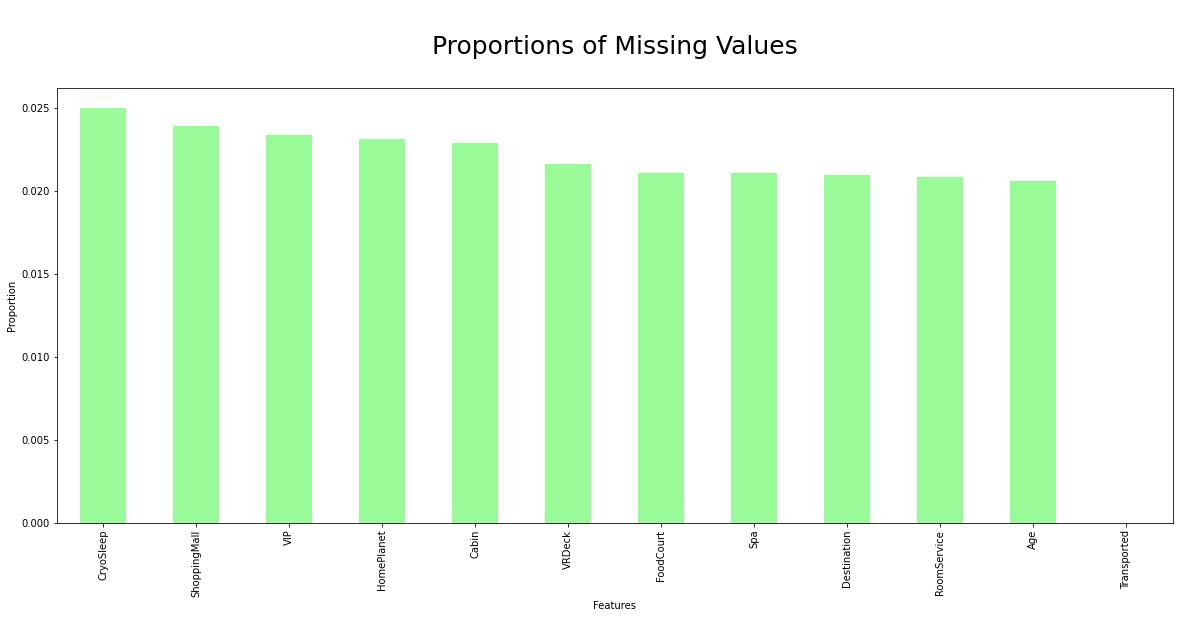

In [11]:
#Showing repartition of missing data 
plt.figure(figsize=(20,8))
(missing/8693).plot(kind="bar", color="palegreen") #400 is the number of patients/rows/examples/observations/lines in our data
#The "missing" variable contains the numbers of missing values, so we divide by 400 to get the proportions.
plt.title('\nProportions of Missing Values\n', fontsize=25)
plt.ylabel("Proportion")
plt.xlabel("Features")
plt.show()

Okay so missing values are repartitioned quite evenly, so we're gonna have to figure out in the preprocessing stage how to deal with those.

I want to check for data correlation but since it only applies for numerical values, we're gonna have to encode the categorical values.

<FONT size="5pt">Categorical features: </FONT>.

As we saw already, except for VIP, the categorical values presented here are very unique cases, For example: The 'Cabin' feature presents alot of different values, so known methods such as LabelEncoder,OneHotEncoder etc.. can be used but will come up short. 

So the idea is, we'll treat each feature seperately!

**Cabin:**

In [12]:
#Checking for value counts
train.Cabin.value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

From the data description:

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [13]:
#Splitting the cabin into 3 features: Number, Side, Deck!
s = train['Cabin'].str.split('/')
deck = []
side = []
numb = []
for i in s.values:
  if type(i) == float: 
    deck.append(np.nan)
    side.append(np.nan)
    numb.append(np.nan)
  else:
    deck.append(i[0])
    side.append(i[2])
    numb.append(i[1])
train['Deck'] = deck
train['Side'] = side
train['Numb'] = numb
train = train.drop('Cabin', axis=1)

s = test['Cabin'].str.split('/')
deck = []
side = []
numb = []
for i in s.values:
  if type(i) == float: 
    deck.append(np.nan)
    side.append(np.nan)
    numb.append(np.nan)
  else:
    deck.append(i[0])
    side.append(i[2])
    numb.append(i[1])
test['Deck'] = deck
test['Side'] = side
test['Numb'] = numb
test = test.drop('Cabin', axis=1)

In [14]:
train.Deck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

In [15]:
train.Deck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

In [16]:
train['Deck'].isna().sum()

199

In [17]:
#filling missing values
train['Deck'].fillna(train['Deck'].mode()[0], inplace=True)

In [18]:
train.Deck.value_counts()

F    2993
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

Well all of em went to the 'F' value and that's fine.

In [19]:
#Doing the same with the test data
test['Deck'] = test.Deck.fillna('F')
test.Deck.value_counts()

F    1545
G    1222
E     447
B     362
C     355
D     242
A      98
T       6
Name: Deck, dtype: int64

In [20]:
train.Side.value_counts()

S    4288
P    4206
Name: Side, dtype: int64

In [21]:
train['Side'].isna().sum()

199

In [22]:
test.Side.value_counts()

S    2093
P    2084
Name: Side, dtype: int64

# Side Note 2: 
Tried using knn imputer since  the Side feature seems so evenly split, so i didn't wna mess with that. But that went completely wrong! :p

So replacing with 'S' value since it seems as the most frequent one.

In [23]:
train['Side'] = train.Side.fillna('S')
test['Side'] = test.Side.fillna('S')

I made a mistake so i had to reset, apparently for the 'Numb' feature, filling it with the most frequent one like I did with the other 2 causes a major imbalance in the data set. 

Let me show you what i mean.

In [24]:
train.Numb.isna().sum()

199

In [25]:
train.Numb.value_counts()

82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: Numb, Length: 1817, dtype: int64

200 nan values, but injecting those values into the most frequent one isnt a good idea, since the number of nan values >>>> the most frequent value!

In [26]:
#Going to be using ffill for this one, which basicly takes the value in front of it.
train['Numb']=train.Numb.fillna(method='ffill')
train.Numb.value_counts()

82      28
19      24
86      22
97      21
176     21
        ..
1548     1
956      1
1547     1
1544     1
1894     1
Name: Numb, Length: 1817, dtype: int64

I like the partition here alot more!

In [27]:
train.Numb.isna().sum()

0

In [28]:
#Same thing for the test set
test['Numb']=test.Numb.fillna(method='ffill')
test.Numb.value_counts()

4       21
31      18
197     16
294     16
34      15
        ..
904      1
1174     1
356      1
918      1
1503     1
Name: Numb, Length: 1505, dtype: int64

In [29]:
test.Numb.isna().sum()

0

In [30]:
train['Numb'] = np.array(train.Numb.values, dtype=int)
test['Numb'] = np.array(test.Numb.values, dtype=int)

**HomePlanet**

In [31]:
print(train.HomePlanet.isna().sum())
print(test.HomePlanet.isna().sum())

201
87


In [32]:
print(train.HomePlanet.value_counts(), '\n')
print(test.HomePlanet.value_counts())

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64 

Earth     2263
Europa    1002
Mars       925
Name: HomePlanet, dtype: int64


Well, we can inject these values into the most frequent, shouldnt be a problem since the values are high enough that it wouldnt cause an imbalance in the data.

In [33]:
train['HomePlanet'] = train.HomePlanet.fillna('Earth')
test['HomePlanet'] = test.HomePlanet.fillna('Earth')

**CryoSleep**

In [34]:
print(train.CryoSleep.isna().sum())
print(test.CryoSleep.isna().sum())
print(train.CryoSleep.value_counts(), '\n')
print(test.CryoSleep.value_counts())

217
93
False    5439
True     3037
Name: CryoSleep, dtype: int64 

False    2640
True     1544
Name: CryoSleep, dtype: int64


Same situation as HomePlanet!

In [35]:
train['CryoSleep'] = train.CryoSleep.fillna(False)
test['CryoSleep'] = test.CryoSleep.fillna(False)

**Destination**

In [36]:
print(train.Destination.value_counts(), '\n')
print(test.Destination.value_counts())

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64 

TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: Destination, dtype: int64


In [37]:
train['Destination'] = train.Destination.fillna('TRAPPIST-1e')
test['Destination'] = test.Destination.fillna('TRAPPIST-1e')

**VIP**

In [38]:
print(train.VIP.value_counts(), '\n')
print(test.VIP.value_counts())

False    8291
True      199
Name: VIP, dtype: int64 

False    4110
True       74
Name: VIP, dtype: int64


In [39]:
train['VIP'] = train.VIP.fillna(False)
test['VIP'] = test.VIP.fillna(False)

Well that about concludes the categorical features that needs attention in my opinion!

I also apologize for the lack of figures, But those features are really hard to plot :/


<FONT size="5pt">Numerical features: </FONT>.

The idea here, is using the median value to fill nan values, since it doesnt get affected by outliers as much as the mean method does!

To save time, I'll do that for all numerical values!

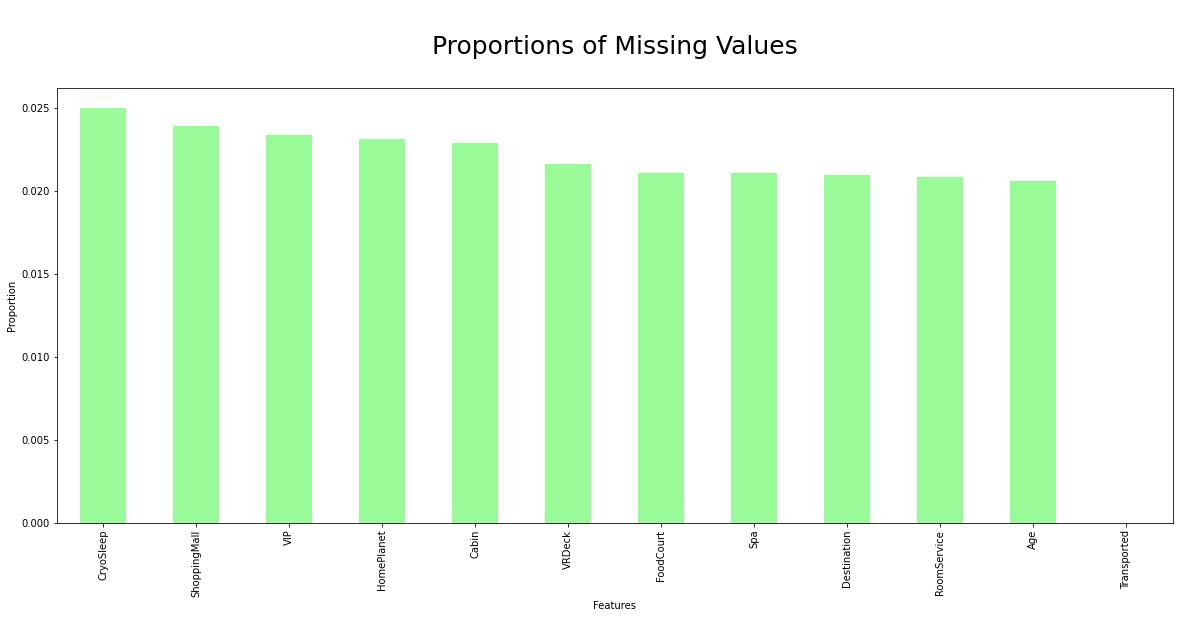

In [40]:
#Data before filling nan with median
plt.figure(figsize=(20,8))
(missing/8693).plot(kind="bar", color="palegreen") #400 is the number of patients/rows/examples/observations/lines in our data
#The "missing" variable contains the numbers of missing values, so we divide by 400 to get the proportions.
plt.title('\nProportions of Missing Values\n', fontsize=25)
plt.ylabel("Proportion")
plt.xlabel("Features")
plt.show()

In [41]:
for i in num_cols:
       train[i].fillna(train[i].mean(), inplace=True)

In [42]:
missing=train.isna().sum().sort_values(ascending=False)

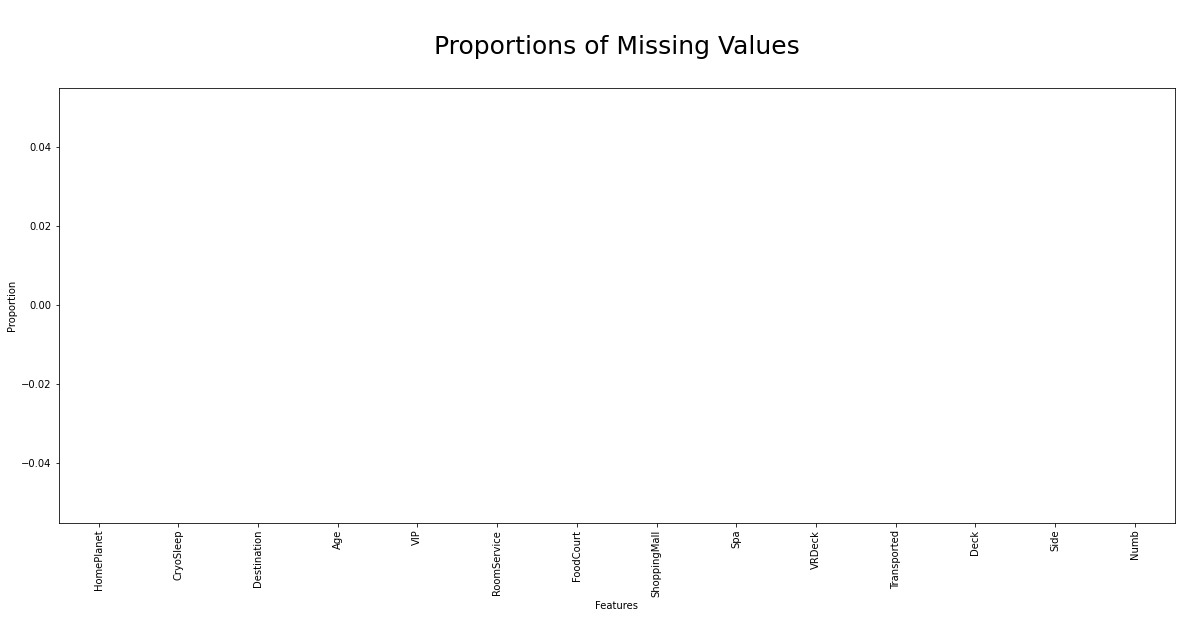

In [43]:
#Data after filling nan with median
plt.figure(figsize=(20,8))
(missing/8693).plot(kind="bar", color="palegreen") #400 is the number of patients/rows/examples/observations/lines in our data
#The "missing" variable contains the numbers of missing values, so we divide by 400 to get the proportions.
plt.title('\nProportions of Missing Values\n', fontsize=25)
plt.ylabel("Proportion")
plt.xlabel("Features")
plt.show()

These plots were unnecessary but cool :p

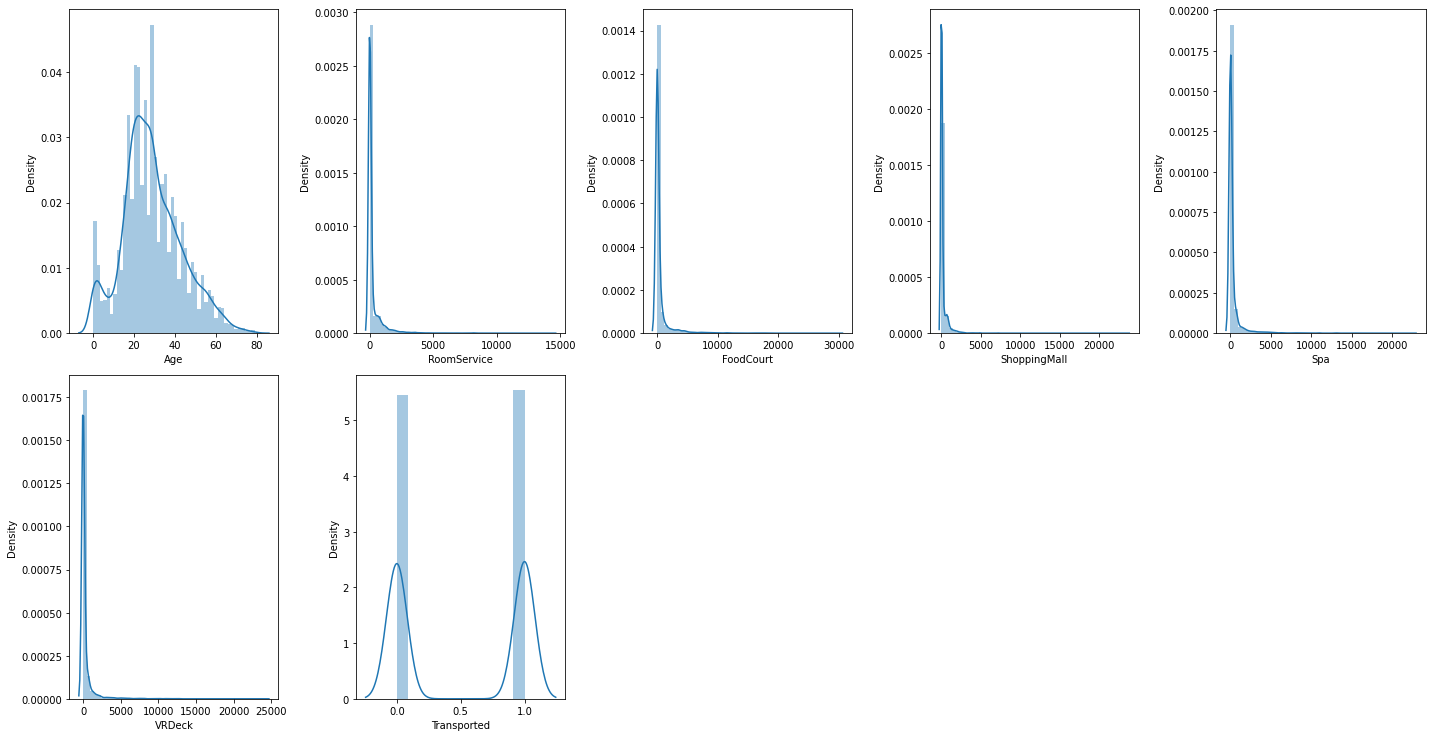

In [44]:
#Checking the distribution of the numerical values !
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(train[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

Nothing much has changed, which is good news! So now to deal with the skeweness of the values, we have to transform the data as well as deal with possible outliers.